# Summary

Exploration of a geomorphic Hamiltonian for hillslopes & rockslopes.

The basic premise is that surface-normal erosion takes place at a rate (speed) $\xi^{\perp}_s$ dependent only on surface angle $\beta$. 
This rate is modelled as an exponential activation function of the form
\begin{equation}
    \xi^{\perp}_s(\beta) = \xi^{\perp_0}_s  \exp\!\left[1- \left(\dfrac{\sin\phi}{|\sin\beta|}\right)^{\!n\,} \right]
\end{equation}

where $\phi$ is a reference threshold angle, $n$ is a hack to control the abruptness of the switch from low to high erosion rates with angle $\beta$, and $\xi^{\perp_0}_s$ is a base erosion rate. A model variation employs a $\tan$ rather than $\sin$ function. See the "Erosion function" section for demo plots of the erosion model.

This model states that surface-normal erosion of a hillslope/rockslope is essentially zero for surface angles $\beta \lesssim \phi$ and fast for $\beta \gtrsim \phi$. 

This notebook uses SymPy to derives the following:

1. the fundamental function $\mathcal{F}_*(\mathbf{p},\mathbf{r})$ corresponding to this slope erosion model
2. the subsequent geomorphic Hamiltonian $\mathcal{H}(\mathbf{p},\mathbf{r})$
3. Hamilton's ray tracing equations $\dot{\mathbf{r}}$ and $\dot{\mathbf{p}}$
4. the critical angle(s) at which the Hessian of $\mathcal{H}(\mathbf{p},\mathbf{r})$ is singular, which is where (at what slope angle $\beta$) the link between the Hamiltonian and Lagrangian spaces is broken, and where we see a transition from convexity to concavity.

It then plots the following:

1. the shape of the normal slowness figuratrix $\mathcal{F}_*(\mathbf{p},\mathbf{r}) = 1$
2. the the ray velocity indicatrix $\mathcal{F}(\mathbf{v},\mathbf{r})=1$

annotated to highlight any convexo-concavity.

We find that for the $\sin$ model (for all $n$) the figuratrix and indicatrix are always convexo-concave. For smaller values of $n$, convexity is seen for $\beta < \beta_{\mathrm{crit}}$, and concavity for $\beta> \beta_{\mathrm{crit}}$; the transition correlates with the erosion threshold, with $\beta_{\mathrm{crit}} \approx \phi$.  This is also true for the $\tan$ model, except for $n=1$, when the figuratrix and indicatrix are fully convex. Rays always point obliquely *up*. 

For larger $n$ (more abruptly step-like erosion function, for which $\beta_{\mathrm{crit}} \rightarrow \phi$), and for both $\sin$ and $\tan$ models, there is a second concave portion of the figuratrix and indicatrix for steeper $\beta$. Rays point obliquely *down* over this range.

These results suggests that cusp formation will take place as an initial slope profile evolves, with more complexity for sharper (higher $n$) erosion threshold behaviour. Ray traced solutions are needed to investigate this further.

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['Hillslope_sinbeta_phi45_n4']
    # pr_filenames = ['Hillslope_sinbeta_phi45_n10']
    # pr_filenames = ['Hillslope_sinbeta_phi45_n20']
    # pr_filenames = ['Hillslope_tanbeta_phi45_n1']
    # pr_filenames = ['Hillslope_tanbeta_phi45_n2']
    # pr_filenames = ['Hillslope_tanbeta_phi45_n4']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Logging

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(level=logging.INFO, format=f'%(message)s')

### Modules

In [3]:
# Import Numpy
import numpy as np

# Import SymPy and set up latex inline & pretty dict printing
import sympy as sy
from sympy import (
    Eq,
    lambdify,
    sin,
    cos,
    sec,
    Rational,
    sqrt,
    solve,
    N,
    init_printing,
    trigsimp,
    expand,
    rad,
    Symbol,
    Function,
    exp,
    tan,
    asin,
    Abs,
    simplify,
    diff,
    Matrix,
    powsimp,
    factor,
    denom,
    numer,
    re,
    im,
)
from sympy.simplify.fu import TR2

# Set up latex inline printing
init_printing(use_unicode=True, pretty_print=True, wrap_line=True)

# Pretty dict printing etc
from pprint import PrettyPrinter

pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters
from gmplib.plot import GraphingBase

from matplotlib import pyplot as plt

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
# from gme.core.symbols import *
from gme.core.symbols import (
    xi_h0,
    xi_h,
    n_h,
    phi,
    alpha,
    # beta,
    beta_crit,
    Fstar,
    H,
    lmbda,
    rdotx,
    rdotz,
    p,
)
from gme.core.equations import Equations

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if "GME_WORKING_PATH" in os.environ.keys():
    working_path = os.environ["GME_WORKING_PATH"]
    print(
        f"Fetching working path from environment variable GME_WORKING_PATH = {working_path}"
    )
else:
    from gmplib.utils import get_pkg_path
    import gme

    working_path = get_pkg_path(gme)
    print(f"Deducing working path from GME package location = {working_path}")
    del gme

# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path, "Parameters", "Theory")
pr_path, pr_filenames


Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['Hillslope_sinbeta_phi45_n4'])

### Parameter parsing

In [53]:
parameters_dict,_ = import_parameters(pr_path, [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
# [pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/defaults.json
gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/Theory/Hillslope_sinbeta_phi45_n4.json
gmplib.parameters.ParametersNestedGroup: p.job
gmplib.parameters.ParametersNestedGroup: p.model
gmplib.parameters.ParametersNestedGroup: p.solve
gmplib.parameters.ParametersNestedGroup: p.resolve
gmplib.parameters.ParametersNestedGroup: p.plot
gmplib.parameters.ParametersNestedGroup: p.save


# Theory

### Basics

In [5]:
px: Symbol = Symbol(r"p_x", real=True, positive=True)
pz: Symbol = Symbol(r"p_z", real=True, negative=True)
beta:  Symbol = Symbol(r"\beta", real=True, positive=True)

In [6]:
# gmeq = Equations( eta_=pr.model.eta, 
#                   mu_=pr.model.mu, 
#                   beta_type=pr.model.beta_type, 
#                   varphi_type=pr.model.varphi_type, 
# #                   ibc_type=pr.model.ibc_type,
#                   parameters=sub, 
#                   do_raw=False )

In [7]:
prefix = ("_").join(
    [
        pr.job.short_name,
        pr.model.beta_type + "beta",
        f"n{pr.model.n_h}",
        f"phi{np.rad2deg(float(N(pr.model.phi_h)))}".replace(".","p"),
    ]
)
# prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = ""  # f'_eta{float(N(gmeq.eta_))}'
# suffix += f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.2f}' if gmeq.mu/gmeq.eta==Rational(1,3) \
#                                     else f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.1f}'
# suffix += f'_xiv{float(sy.N(pr.model.xiv_0)):1.0f}'
# suffix = (suffix if pr.model.varphi_type=='ramp' \
#             else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix + suffix.replace(".", "p")
job_name


'hillslope_sinbeta_n4_phi45p0'

### Erosion function

Remember that $p_z$ is NEGATIVE, but $\beta$ is required to be POSITIVE.

In [8]:
hillslope_tan_erosion_eqn = Eq(
    # xi_h(beta), powsimp(xi_h0 * (exp(1 - tan(phi) / tan(beta)) ** n_h))
    xi_h(beta), powsimp(xi_h0 * (exp(1-(tan(phi) / tan(beta))** n_h) ))
)
hillslope_tan_erosion_eqn

In [9]:
hillslope_sin_erosion_eqn = Eq(
    # xi_h(beta), powsimp(xi_h0 * ( exp(n_h - n_h*sin(phi) / Abs(sin(beta))) ))
    # xi_h(beta), powsimp( xi_h0 * (exp(1 - sin(phi) / Abs(sin(beta))))**n_h )
    xi_h(beta), ( xi_h0 * exp(1 - (sin(phi) / Abs(sin(beta)))**n_h) )
    # xi_h(beta), powsimp( xi_h0 * (exp( Abs(sin(beta))/ sin(phi) - 2))**n_h )
)
hillslope_sin_erosion_eqn

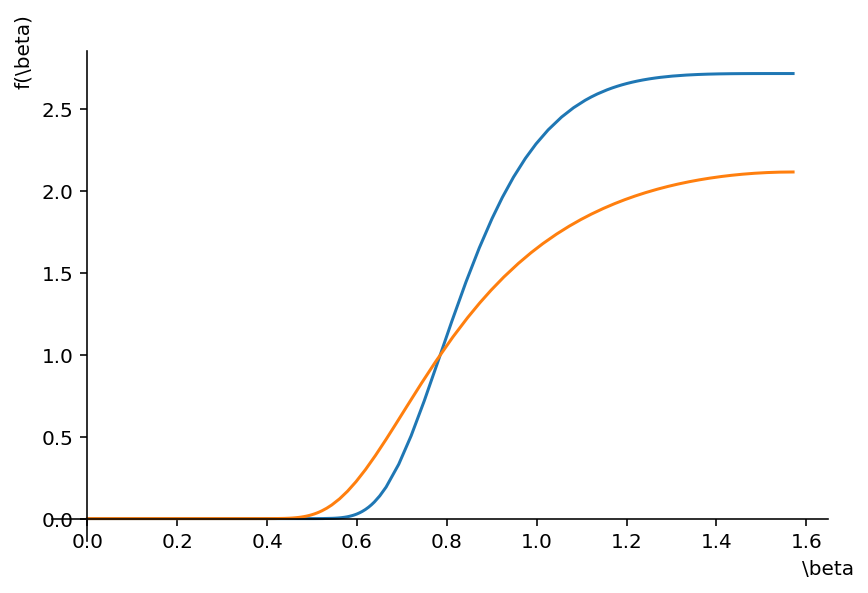

In [10]:
p1 = sy.plot(
    hillslope_tan_erosion_eqn.rhs.subs(
        {phi: pr.model.phi_h, xi_h0: 1, n_h: pr.model.n_h}
    ),
    (beta, 0, sy.pi/2),
    show=False,
)
p2 = sy.plot(
    hillslope_sin_erosion_eqn.rhs.subs(
        {phi: pr.model.phi_h, xi_h0: 1, n_h: pr.model.n_h}
    ),
    (beta, 0, sy.pi/2),
    show=False,
)
p1.extend(p2)
p1.show()
Eq(phi, (pr.model.phi_h).n())

In [11]:
model_ = pr.model.beta_type
if model_=="tan":
    hillslope_erosion_eqn = hillslope_tan_erosion_eqn
elif model_=="sin":
    hillslope_erosion_eqn = hillslope_sin_erosion_eqn
else:
    print("Not implemented")

### Fundamental function & Hamiltonian

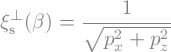

In [12]:
xih_pxpz_eqn = Eq(xi_h(beta), 1/sqrt(px**2+pz**2))
xih_pxpz_eqn

In [13]:
hillslope_erosion_eqn

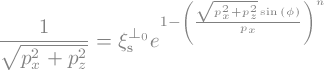

In [14]:
hillslope_pxpz_eqn = (
    hillslope_erosion_eqn
        .subs(e2d(xih_pxpz_eqn))
        .subs({tan(beta):(-px/pz)})
        .subs({sin(beta):(px/sqrt(px**2+pz**2))})
)
hillslope_pxpz_eqn

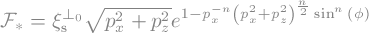

In [15]:
Fstar_hillslope_pxpz_eqn = Eq(
    Fstar,
    solve(simplify(hillslope_pxpz_eqn.subs({px: px/Fstar, pz: pz/Fstar})), Fstar)[
        0
    ],
)
Fstar_hillslope_pxpz_eqn

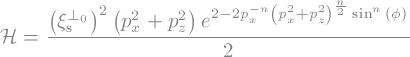

In [16]:
H_hillslope_pxpz_eqn = Eq(H, Fstar_hillslope_pxpz_eqn.rhs**2 / 2)
H_hillslope_pxpz_eqn

Check Euler homogeneity

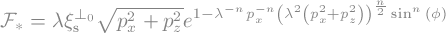

In [17]:
simplify( Fstar_hillslope_pxpz_eqn.subs({px:lmbda*px, pz:lmbda*pz}) )

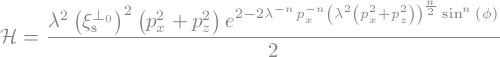

In [18]:
simplify( H_hillslope_pxpz_eqn.subs({px:lmbda*px, pz:lmbda*pz}) )

### Hamilton's equations

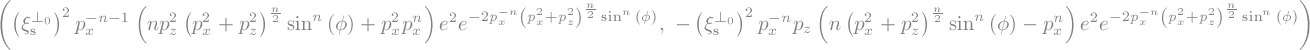

In [19]:
v_pxpz_eqn = Eq(
    Matrix([rdotx, rdotz]),
    Matrix(
        [
            factor(simplify(diff(H_hillslope_pxpz_eqn.rhs, px))),
            factor(simplify(diff(H_hillslope_pxpz_eqn.rhs, pz))),
        ]
    )
)
(
    v_pxpz_eqn.rhs[0],
    v_pxpz_eqn.rhs[1],
)


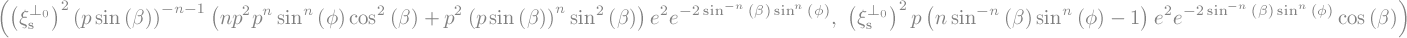

In [20]:
v_p_beta_eqn = (
    trigsimp( v_pxpz_eqn.subs({px:p*sin(beta), pz:-p*cos(beta)}) )
)
(v_p_beta_eqn.rhs[0], v_p_beta_eqn.rhs[1], )


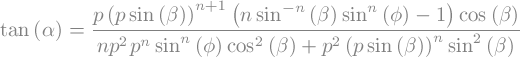

In [21]:
tanalpha_eqn = Eq(
    tan(alpha),
    trigsimp( v_p_beta_eqn.rhs[1]/v_p_beta_eqn.rhs[0] )
)
tanalpha_eqn

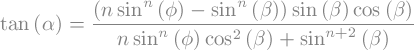

In [22]:
simplify(tanalpha_eqn)

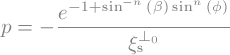

In [23]:
p_conjugate_beta_eqn = Eq(
    p,
    powsimp(solve(
        simplify(
            Eq(
                (v_p_beta_eqn.rhs[0] * px + v_p_beta_eqn.rhs[1] * pz).subs(
                    {px: p*sin(beta), pz: -p*cos(beta)}
                ),
                1,
            )
        ),
        p,
    )[0]),
)
p_conjugate_beta_eqn


### Choose some parameters

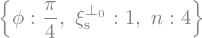

In [24]:
n_ = pr.model.n_h #Rational(1,2)
phi_ = pr.model.phi_h
xi_h0_ = pr.model.xi_h0

beta_ = np.pi/5

sub_ = {xi_h0:xi_h0_, n_h:n_, phi:phi_}
sub_

### Figuratrix

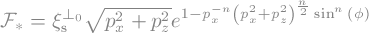

In [25]:
Fstar_hillslope_pxpz_eqn

In [26]:
fgtx_raw_eqn = simplify(
    Fstar_hillslope_pxpz_eqn
        .subs({Fstar:1})
        .subs({px:p*sin(beta), pz:-p*cos(beta)})
)
fgtx_raw_eqn

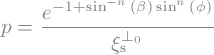

In [27]:
fgtx_p_beta_eqn = Eq(
    p,
    solve( fgtx_raw_eqn, p )[0]
)
fgtx_p_beta_eqn

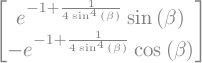

In [28]:
p_covec_fn_ = Matrix([
    (fgtx_p_beta_eqn.rhs*sin(beta)).subs(sub_),
    (-fgtx_p_beta_eqn.rhs*cos(beta)).subs(sub_)
])
# sy.plot_parametric( px_fn,pz_fn, (beta,0.2,sy.pi/3) );
p_covec_fn_

In [29]:
px_lmbda_ = lambdify([beta], p_covec_fn_[0])
pz_lmbda_ = lambdify([beta], p_covec_fn_[1])
p_lmbda_ = lambdify([beta], sqrt(p_covec_fn_[0]**2+p_covec_fn_[1]**2))
px_lmbda_(beta_), pz_lmbda_(beta_), p_lmbda_(beta_)

Check conjugacy.

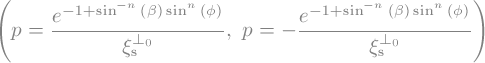

In [30]:
fgtx_p_beta_eqn, p_conjugate_beta_eqn

### Indicatrix

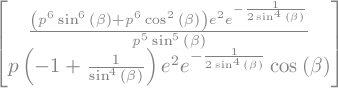

In [31]:
v_vec_fn_ =  v_p_beta_eqn.rhs.subs(sub_)
v_vec_fn_

In [32]:
vx_lmbda_ = lambdify(
    [beta],
    v_vec_fn_[0].subs({p: sqrt(p_covec_fn_[0] ** 2 + p_covec_fn_[1] ** 2)}),
)
vz_lmbda_ = lambdify(
    [beta],
    v_vec_fn_[1].subs({p: sqrt(p_covec_fn_[0] ** 2 + p_covec_fn_[1] ** 2)}),
)
v_lmbda_ = lambdify(
    [beta],
    sqrt(v_vec_fn_[0] ** 2 + v_vec_fn_[1] ** 2).subs(
        {p: sqrt(p_covec_fn_[0] ** 2 + p_covec_fn_[1] ** 2)}
    ),
)
vx_lmbda_(beta_), vz_lmbda_(beta_), v_lmbda_(beta_)


In [33]:
vx_lmbda_(beta_)*px_lmbda_(beta_) + vz_lmbda_(beta_)*pz_lmbda_(beta_)

### Hessian & critical angle(s)

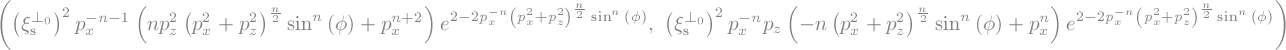

In [34]:
dHdpx = simplify(diff(H_hillslope_pxpz_eqn.rhs,px))
dHdpz = simplify(diff(H_hillslope_pxpz_eqn.rhs,pz))
dHdpx, dHdpz

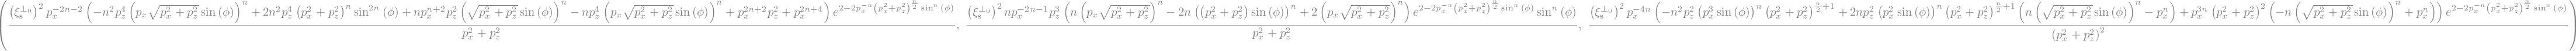

In [35]:
d2Hdpx2 = simplify(diff(dHdpx,px))
d2Hdpxpz = simplify(diff(dHdpx,pz))
d2Hdpz2 = simplify(diff(dHdpz,pz))
d2Hdpx2, d2Hdpxpz, d2Hdpz2

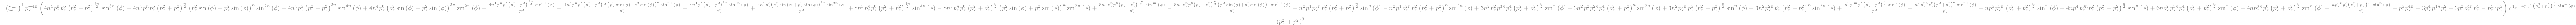

In [36]:
H_Jacobian = factor( d2Hdpx2*d2Hdpz2 - d2Hdpxpz*d2Hdpxpz )
H_Jacobian

In [37]:
# selected_part_H_Jacobian_ = 2
selected_part_H_Jacobian_ = 4 if pr.model.beta_type=="sin" else 3

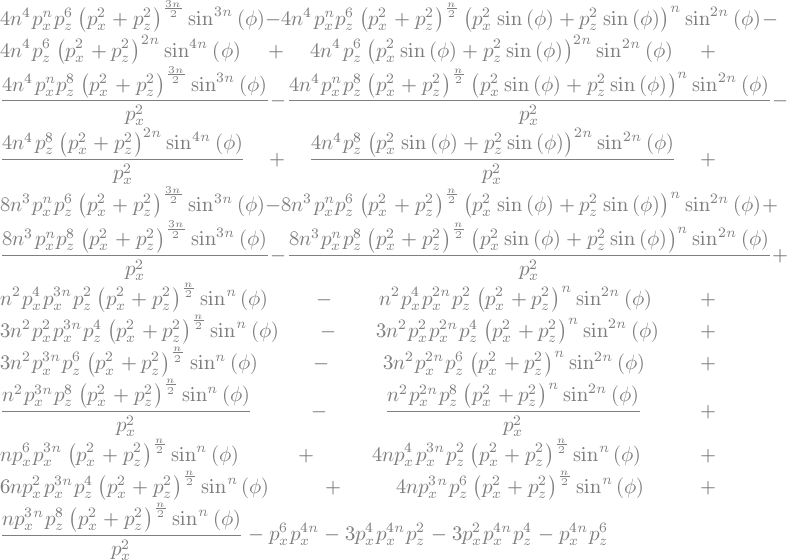

In [38]:
H_Jacobian.args[selected_part_H_Jacobian_]

In [39]:
pzp: Symbol = Symbol(r"p_z^+", real=True, positive=True)
m_h: Symbol = Symbol(r"m", int=True, positive=True)
t_h: Symbol = Symbol(r"t", real=True, positive=True)

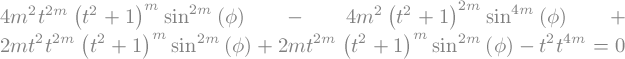

In [40]:
if pr.model.beta_type=="sin":
    H_critical_t_eqn = Eq(expand(expand((
        simplify(
            simplify(
                factor(
                    H_Jacobian.args[selected_part_H_Jacobian_].subs(
                        {px: -pz*tan(beta)}
                    )
                ).subs({pz: -pzp})
            )/ (pzp**(4*n_h+6)*tan(beta)**(2*n_h-2) / cos(beta)**6)
        )).subs({Abs(cos(beta)**n_h):cos(beta)**n_h})
        .subs({Abs(cos(beta)**(2*n_h)):cos(beta)**(2*n_h)})
        .subs({cos(beta):1/sqrt(1+tan(beta)**2)})
    ).subs({n_h:2*m_h, tan(beta):t_h})), 0)
else:
    H_critical_t_eqn = simplify(expand(
        H_Jacobian.args[selected_part_H_Jacobian_]
            .subs({px: -pz*tan(beta),pz: -pzp})
            *tan(beta)**2
            /pzp**(2*n_h+2)
    ).subs({tan(beta):t_h}))
H_critical_t_eqn


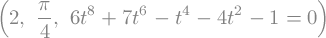

In [41]:
n_h_ = pr.model.n_h
m_h_ = n_h_//2
phi_h_ = pr.model.phi_h

H_critical_t_eqn_ = expand(
    H_critical_t_eqn.subs({n_h:n_h_, m_h:m_h_, phi:phi_h_})
)
m_h_, phi_h_, H_critical_t_eqn_

In [42]:
H_critical_t_poly_ = sy.poly(H_critical_t_eqn_,t_h)
H_critical_t_poly_

In [43]:
tanbeta_crits_ = sorted([
    float(root_)
    for root_ in H_critical_t_poly_.nroots()
    if Abs(im(root_)) < 1e-10 and re(root_) > 0
])
beta_crits_ = [np.arctan(tanbeta_crit_) for tanbeta_crit_ in tanbeta_crits_]
beta_crits_, [np.rad2deg(beta_crit_) for beta_crit_ in beta_crits_]

In [44]:
# tanbeta_crits_ = sorted([
#     float(sqrt(re(soln_.n())))
#     for soln_ in solve(H_critical_t_rearranged_eqn_, t ** 2)
#     if re(soln_.n()) > 0
# ])
# beta_crits_ = [np.arctan(tanbeta_crit_) for tanbeta_crit_ in tanbeta_crits_]
# [np.rad2deg(beta_crit_) for beta_crit_ in beta_crits_]


# Plot

### Prep

In [45]:
gr = GraphingBase()

In [54]:
beta_array = np.linspace(0.01,np.pi/2*1,500)
px_array = px_lmbda_(beta_array) 
pz_array = pz_lmbda_(beta_array)
vx_array = vx_lmbda_(beta_array)
vz_array = vz_lmbda_(beta_array)
beta_array = beta_array[np.isfinite(vx_array)]
px_array = px_array[np.isfinite(vx_array)]
pz_array = pz_array[np.isfinite(vx_array)]
vz_array = vz_array[np.isfinite(vx_array)]
vx_array = vx_array[np.isfinite(vx_array)]

phi_str = str(pr.model.phi_h).replace("pi","$\pi$")

# beta_array

In [55]:
def patch_idtx_fgtx_markers():
    n_beta_crit = len(beta_crits_)
    for angle_markup_ in pr.plot.idtx_fgtx_markers:
        if "beta_crit" in angle_markup_["angle"]:
            for idx, beta_crit_ in enumerate(beta_crits_):
                patched_angle_markup_ = angle_markup_.copy()
                patched_angle_markup_["angle"] = sy.parse_expr(
                    angle_markup_["angle"].replace("beta_crit", f"{beta_crit_}")
                ).n()
                patched_angle_markup_["label"] = angle_markup_["label"].replace(
                    "=beta_crit", (f"({idx+1})" if n_beta_crit>1 else "")
                    +f"={np.rad2deg(beta_crit_):0.1f}"
                )
                patched_angle_markup_["marker"] = angle_markup_["marker"][
                    min((idx, 1))
                ]
                yield(patched_angle_markup_)
        else:
            patched_angle_markup_ = angle_markup_.copy()
            patched_angle_markup_["angle"] = sy.parse_expr(
                angle_markup_["angle"].replace("phi_h", f"{pr.model.phi_h}")
            ).n()
            patched_angle_markup_["label"] = angle_markup_["label"].replace(
                "=phi_h", f"={np.rad2deg(float(pr.model.phi_h)):0.1f}"
            )
            yield(patched_angle_markup_)

idtx_fgtx_markers_ = sorted(
    list(patch_idtx_fgtx_markers()),
    key=lambda angle_markup: angle_markup["angle"],
)

def mark_angles(x_lmbda_, z_lmbda_, p_or_v=0):
    for angle_markup_ in reversed(idtx_fgtx_markers_):
        angle_ = angle_markup_["angle"]
        plt.plot(
            x_lmbda_(float(angle_)),
            z_lmbda_(float(angle_)),
            angle_markup_["marker"],
            color=angle_markup_["colors"][p_or_v],
            label=angle_markup_["label"],
            ms=angle_markup_["size"],
        )
        # print(angle_, x_lmbda_(float(angle_)), z_lmbda_(float(angle_)),)
            
idtx_fgtx_markers_

[{'angle': 0.220000000000000,
  'colors': ['DarkBlue', 'DarkRed'],
  'marker': 'o',
  'label': '$\\beta \\rightarrow 0\\degree$',
  'size': 6},
 {'angle': 0.707621502634454,
  'colors': ['lightseagreen', 'violet'],
  'marker': '^',
  'label': '$\\beta_\\mathrm{crit}=40.5\\degree$',
  'size': 9},
 {'angle': 0.785398163397448,
  'colors': ['DarkBlue', 'DarkRed'],
  'marker': 'h',
  'label': '$\\beta=\\phi=45.0\\degree$',
  'size': 9},
 {'angle': 1.57079632679490,
  'colors': ['b', 'r'],
  'marker': 's',
  'label': '$\\beta=90\\degree$',
  'size': 6}]

### Graphs

gmplib.plot.GraphingBase:
   Creating plot: hillslope_sinbeta_n4_phi45p0_figuratrix size=(8, 8) @ 100 dpi
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode


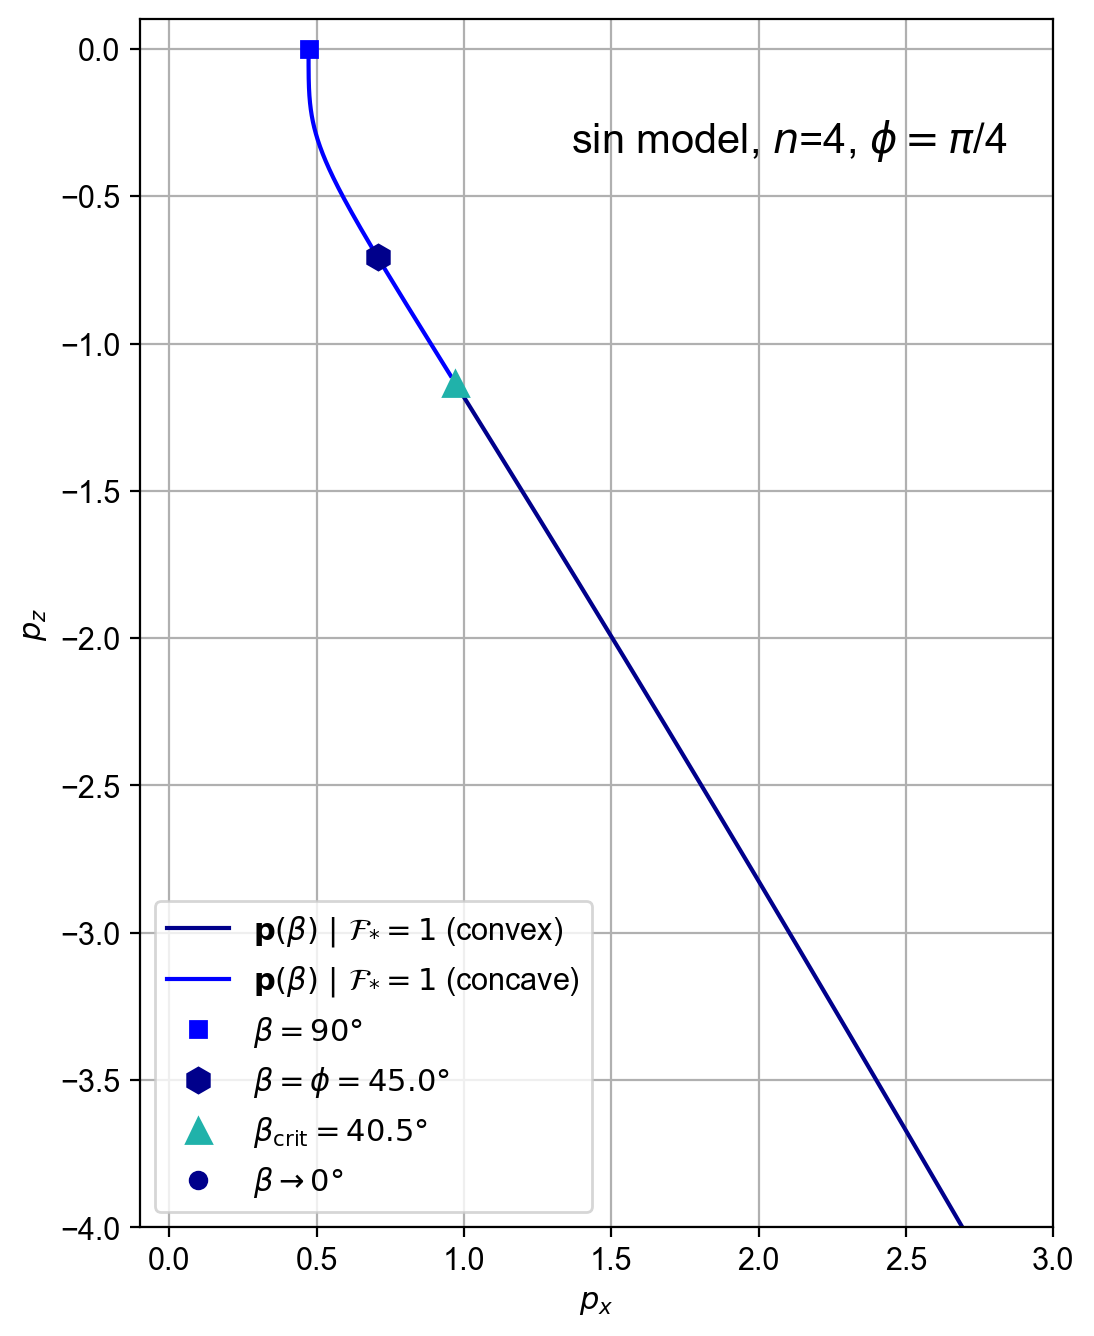

In [56]:
gr.create_figure(fig_name="_".join([job_name, "figuratrix"]))
if beta_crits_ is not None:
    prev_beta_crit_ = 0
    for beta_crit_, color_, concave_or_convex in zip(
        (beta_crits_ + [np.pi / 2]),
        (
            "DarkBlue",
            "blue",
            "blueviolet",
        ),
        ("convex", "concave", "convex"),
    ):
        plt.plot(
            px_array[
                (beta_array >= prev_beta_crit_) & (beta_array <= beta_crit_)
            ],
            pz_array[
                (beta_array >= prev_beta_crit_) & (beta_array <= beta_crit_)
            ],
            color=color_,
            label=r"$\mathbf{p}(\beta) \,\,|\,\,\mathcal{F}_{*}=1$ "
            + f"({concave_or_convex})",
        )
        prev_beta_crit_ = beta_crit_
plt.xlabel(r"$p_x$")
plt.ylabel(r"$p_z$")
mark_angles(px_lmbda_, pz_lmbda_, p_or_v=0)
if pr.plot.fgtx_xlim is not None:
    plt.xlim(*pr.plot.fgtx_xlim)
if pr.plot.fgtx_ylim is not None:
    plt.ylim(*pr.plot.fgtx_ylim)
axes = plt.gca()
axes.set_aspect(1)
plt.text(
    *pr.plot.fgtx_label_loc,
    rf"{pr.model.beta_type} model, $n$={pr.model.n_h}, " + rf"$\phi=${phi_str}",
    horizontalalignment="right",
    verticalalignment="center",
    transform=axes.transAxes,
    fontsize=15,
)
plt.grid(":")
plt.legend(loc=pr.plot.fgtx_legend_loc);

gmplib.plot.GraphingBase:
   Creating plot: hillslope_sinbeta_n4_phi45p0_indicatrix size=(8, 8) @ 100 dpi
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode


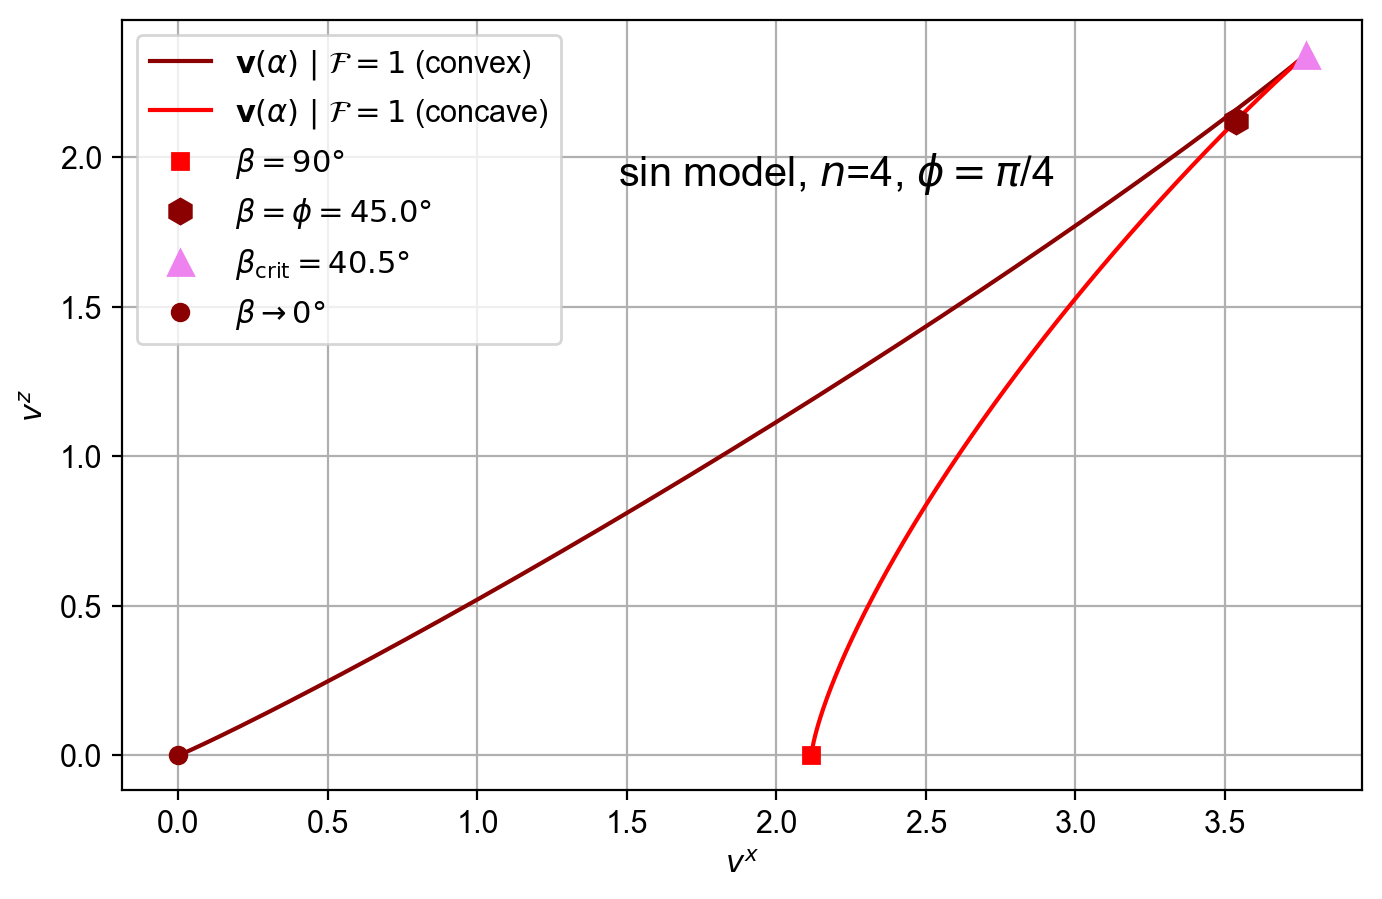

In [57]:
gr.create_figure(fig_name="_".join([job_name, "indicatrix"]))
if beta_crits_ is not None:
    prev_beta_crit_ = 0
    for beta_crit_, color_, concave_or_convex in zip(
        (beta_crits_ + [np.pi / 2]),
        (
            "DarkRed",
            "red",
            "darkorange",
        ),
        ("convex", "concave", "convex"),
    ):
        plt.plot(
            vx_array[
                (beta_array >= prev_beta_crit_) & (beta_array <= beta_crit_)
            ],
            vz_array[
                (beta_array >= prev_beta_crit_) & (beta_array <= beta_crit_)
            ],
            color=color_,
            label=r"$\mathbf{v}(\alpha) \,\,|\,\,\mathcal{F}=1$ "
            + f"({concave_or_convex})",
        )
        prev_beta_crit_ = beta_crit_
plt.xlabel(r"$v^x$")
plt.ylabel(r"$v^z$")
mark_angles(vx_lmbda_, vz_lmbda_, p_or_v=1)
if pr.plot.idtx_xlim is not None:
    plt.xlim(*pr.plot.idtx_xlim)
if pr.plot.idtx_ylim is not None:
    plt.ylim(*pr.plot.idtx_ylim)
axes = plt.gca()
axes.set_aspect(1)
plt.text(
    *pr.plot.idtx_label_loc,
    rf"{pr.model.beta_type} model, $n$={pr.model.n_h}, " + rf"$\phi=${phi_str}",
    horizontalalignment="left",
    verticalalignment="center",
    transform=axes.transAxes,
    fontsize=15,
)
plt.grid(":")
plt.legend(loc=pr.plot.idtx_legend_loc, fontsize=pr.plot.idtx_fontsize);

# Save

In [50]:
pp(gr.fdict)

{   'hillslope_sinbeta_n4_phi45p0_figuratrix': <Figure size 800x800 with 1 Axes>,
    'hillslope_sinbeta_n4_phi45p0_indicatrix': <Figure size 800x800 with 1 Axes>}


In [51]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots(
    gr.fdict,
    plots_dir,
    pr.save.figs_format,
    suffix="",
    dpi=pr.save.figs_options["dpi"],
)

gmplib.save.export_plots:
   Writing to dir: "/Users/colinstark/Projects/GME/Plots/Notes"
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
gmplib.save.export_plot: Exported "hillslope_sinbeta_n4_phi45p0_figuratrix.jpg"
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
gmplib.save.export_plot: Exported "hillslope_sinbeta_n4_phi45p0_indicatrix.jpg"
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
gmplib.save.export_plot: Exported "hillslope_sinbeta_n4_phi45p0_figuratrix.pdf"
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicod